<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/ds-project-line-simplification-spatial-join/blob/main/starting-code/project_my_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1: Importing and reading the data

##A: upload the necessary libraries

In [ ]:
!pip install folium
!pip install uszipcode
%pip install pygeohash
!pip install geopandas

In [2]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from IPython.display import Image
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
from folium import plugins
from datetime import datetime
import datetime as dt
import json
from scipy import stats
import matplotlib.pyplot as plt

import os

##B: Read csv and geojson

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#trips = pd.read_csv("/content/drive/MyDrive/foundation project/NYC_Pilot2_PM_Part1.csv")

In [5]:
trips = pd.read_csv("https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv")

In [ ]:
#geojson_file = "/content/drive/MyDrive/foundation project/nyc_polygon.geojson"

In [4]:
geojson_file = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"

In [7]:
import geopandas as gpd
neighborhoods_original = gpd.read_file(geojson_file)

##C: Preprocessing

In [6]:
trips.shape

(169999, 31)

In [8]:
#Remove erroneous coordinates (0,0) from the dataset
trips = \
trips[(trips['latitude'] != 0 ) & \
(trips['longitude']!=0 )]

In [9]:
trips.shape[0] #return the size

169999

In [10]:
trips.head(1)

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,0,0,0,23.7,57.3,4.508813


In [11]:
#converting trips and polygons into geoPandas
import geopandas as gpd
gdf_trips = gpd.GeoDataFrame(trips,   geometry=gpd.points_from_xy(trips.longitude, trips.latitude))

In [12]:
type(gdf_trips)

geopandas.geodataframe.GeoDataFrame

In [13]:
#chech the Coordinate Reference System.
print(gdf_trips.crs)

None


In [14]:
#reproject the CRS
gdf_trips = gdf_trips.set_crs('epsg:4326')

In [15]:
#read the data into GeoDataFrame
neighborhoods_original = gpd.read_file(geojson_file)

In [16]:
neighborhoods_original.shape

(310, 5)

In [17]:
neighborhoods_original.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
sjoined_trips_original = gpd.sjoin(gdf_trips, neighborhoods_original, predicate="within")
sjoined_trips_original.head(2)
#we preformed a spatial join here

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin23,temperature,humidity,pm25,geometry,index_right,neighborhood,boroughCode,borough,@id
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,23.7,57.3,4.508813,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,23.7,57.8,5.462420,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...


##D: Heat Map

In [19]:
from folium.plugins import HeatMap

In [20]:
heatmap_data = sjoined_trips_original[['longitude','latitude','neighborhood']].groupby(['neighborhood'], as_index=False).agg({'longitude': 'first', 'latitude': 'first','neighborhood':'count'})

In [21]:
heatmap_data.rename(columns={'neighborhood': 'count'}, inplace=True)

In [22]:
new_heatmap_data=heatmap_data.sort_values(by='count', ascending=False)

In [23]:
new_heatmap_data.head(2)

,longitude,latitude,count
21,-73.885902,40.827667,42523
3,-73.869316,40.847672,39495


In [24]:
heatmap_data1 = new_heatmap_data.values.tolist() # a list

In [25]:
trips['count'] = 1

In [26]:
trips[['latitude', 'longitude', 'count']].sample(n=10000)

,latitude,longitude,count
112362,40.820084,-73.893883,1
139224,40.820572,-73.899803,1
78678,40.811329,-73.922264,1
70622,40.845375,-73.870659,1
7206,40.844681,-73.871040,1
...,...,...,...
4778,40.805504,-73.924454,1
44468,40.847130,-73.869934,1
91543,40.846531,-73.870110,1
129986,40.845882,-73.870338,1


In [27]:
len(trips[['latitude', 'longitude', 'count']].sample(n=10000).groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())

8859

In [28]:
def generateBaseMap(default_location=[40.7306, -73.935], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [29]:
base_map = generateBaseMap()
HeatMap(data=trips[['latitude', 'longitude', 'count']].sample(n=10000).groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

In [ ]:
base_map

#Part 2: DP simplifier

##A: using Shapley

In [30]:
#apply Shapely's .simplify() method to reduce the geometries to reduce their complexity
#The output is still a GeoJSON file, but with simplified geometries that maintain the overall shape with fewer points.
from json import load, dump
from shapely.geometry import LineString, Point, Polygon
from sys import argv
from os.path import isfile


def simplify_geojson(input_file, output_file, tolerance=0.01,preserve_topology=True): #preserve topology insure that no over lapping between the polygons, also reduce the tolerance for less overlapping
    with open(input_file, 'r') as f:
        data = load(f)
    if 'features' in data:
        simplified_features = []
        for feature in data['features']:
            geometry = feature['geometry']
            if geometry['type'] == 'LineString':
                feature['geometry']['coordinates'] = LineString(
                    geometry['coordinates']).simplify(tolerance, preserve_topology=True).coords[:]
            elif geometry['type'] == 'Point':
                pass
            elif geometry['type'] == 'Polygon':
                simplified_exterior = LineString(geometry['coordinates'][0]).simplify(
                    tolerance, preserve_topology=True)
                simplified_interiors = [LineString(interior).simplify(
                    tolerance, preserve_topology=True) for interior in geometry['coordinates'][1:]]
                feature['geometry']['coordinates'] = [
                    simplified_exterior.coords[:]] + [i.coords[:] for i in simplified_interiors]
            elif geometry['type'] == 'MultiPolygon':
                simplified_polygons = []
                for polygon in geometry['coordinates']:
                    simplified_exterior = LineString(polygon[0]).simplify(
                        tolerance, preserve_topology=True)
                    simplified_interiors = [LineString(interior).simplify(
                        tolerance, preserve_topology=True) for interior in polygon[1:]]
                    simplified_polygons.append(
                        [simplified_exterior.coords[:]] + [i.coords[:] for i in simplified_interiors])
                feature['geometry']['coordinates'] = simplified_polygons
            else:
                print(
                    f'Warning: Unsupported geometry type "{geometry["type"]}"')
            simplified_features.append(feature)
        data['features'] = simplified_features
    with open(output_file, 'w') as f:
        dump(data, f)

def verifyArgv():
    try:
        if len(argv)<4:
            raise Exception("3 parameters required \n simplifier.py input.jeojson output.geojson accuracy percentage")
        elif not isfile(argv[1]):
            raise Exception(argv[1],"file not found. ")
        elif isfile(argv[2]):
            raise Exception(argv[2],"file is already exist. ")
        elif int(argv[3]) not in range(0,101):
            raise Exception("accuracy value should be in between 1-100. ")
        output_data = simplify_geojson(
    argv[1], argv[2], float(argv[3]))
    except Exception as e:
        print(e)

verifyArgv()

3 parameters required 
 simplifier.py input.jeojson output.geojson accuracy percentage


In [ ]:
'''geojson_file_simplified = '/content/drive/MyDrive/foundation project/simplified_data.geojson' #create a path for the simplifed file in the drive
simplify_geojson(geojson_file, geojson_file_simplified, tolerance=0.01) #run it with specific tolerance'''

In [34]:
geojson_file_simplified = '/content/drive/MyDrive/Foundations_of_data_Science/projects/output/simplified_data.geojson' #create a path for the simplifed file in the drive
#simplify_geojson(geojson_file, geojson_file_simplified, tolerance=0.01) #run it with specific tolerance

In [35]:
neighborhoods_original_simplified = gpd.read_file(geojson_file_simplified) #read it as geopandas

In [36]:
#try to fix over laps using buffer (0)
neighborhoods_original_simplified['geometry'] = neighborhoods_original_simplified['geometry'].buffer(0)
#what does the buffer(0) do?
#can often resolve small self-intersections or other geometric anomalies that might lead to overlaps after simplification.

In [37]:
sjoined_neighborhoods_original_simplified = gpd.sjoin(gdf_trips, neighborhoods_original_simplified, predicate="within") #preform special join for the original geoDataFrame

In [38]:
#creating a map for the simplifed file
import folium

# Create a base map (adjust the location and zoom to fit your data)
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add the GeoJSON overlay to the folium map
folium.GeoJson(neighborhoods_original_simplified, name="simplified_geometry").add_to(m)

# Display the map
m

##B: Comparison analysis of Shapley

In [39]:
#define a function that count the vertices
def count_vertices(geom):
    if geom.geom_type == 'Polygon':
        return len(geom.exterior.coords)
    elif geom.geom_type == 'MultiPolygon':
        return sum(len(p.exterior.coords) for p in geom)
    return 0

In [40]:
#Iterate Over Tolerance Values and Simplify
tolerances = np.arange(0.001, 0.01, 0.001) #test different tolerances

# Lists to store total vertices counts for each tolerance
original_vertices = []
simplified_vertices = []

# Ensure that the lists are clear before the loop starts
original_vertices.clear()
simplified_vertices.clear()

for tol in tolerances:
    neighborhoods_original_simplified['geometry'] = neighborhoods_original['geometry'].apply(
        lambda geom: geom.simplify(tol, preserve_topology=True))

    # Count vertices
    orig_count = neighborhoods_original['geometry'].apply(count_vertices).sum()
    simp_count = neighborhoods_original_simplified['geometry'].apply(count_vertices).sum()

    # Append the counts
    original_vertices.append(orig_count)
    simplified_vertices.append(simp_count)


print('Original Vertices Counts:', original_vertices)
print('Simplified Vertices Counts:', simplified_vertices)

assert len(tolerances) == len(original_vertices) == len(simplified_vertices), "Mismatch in the number of elements"



Original Vertices Counts: [32388, 32388, 32388, 32388, 32388, 32388, 32388, 32388, 32388]
Simplified Vertices Counts: [3864, 2636, 2206, 1975, 1855, 1791, 1715, 1671, 1653]


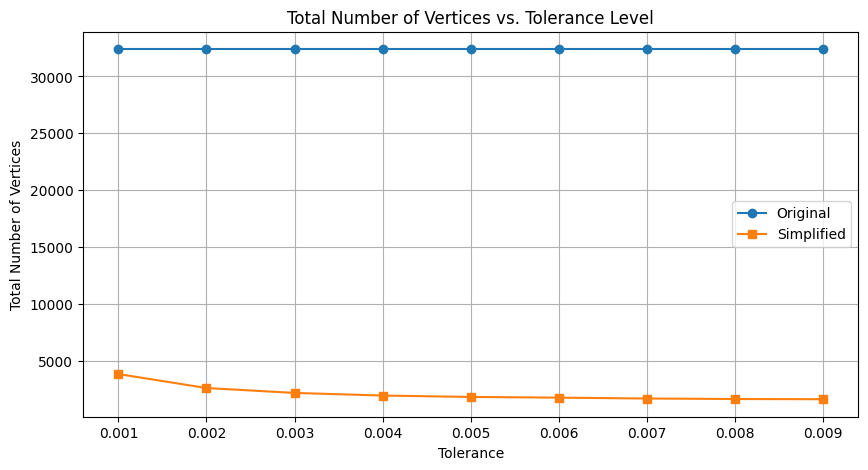

In [42]:
#plotting the total number of vertices against tolerance levels
plt.figure(figsize=(10, 5))
plt.plot(tolerances, original_vertices, marker='o', label='Original')
plt.plot(tolerances, simplified_vertices, marker='s', label='Simplified')

plt.title('Total Number of Vertices vs. Tolerance Level')
plt.xlabel('Tolerance')
plt.ylabel('Total Number of Vertices')
plt.legend()
plt.grid(True)
plt.show()


The unit of computing the area is sqaure meters as the EPSG unit is square meter (EPGS: Equal Earth Projection)
is a type of equal-area projection designed to represent area relationships accurately across the globe.

In [43]:
#patial analysis: Comparing average areas
#re-project the files to EPSG:4326 to compare the area
#EPSG:4326 is not good as it does not consider the curve of the earth
original_gdf_projected = neighborhoods_original.to_crs('EPSG:6933')
simplified_gdf_projected = neighborhoods_original_simplified.to_crs('EPSG:6933')

original_gdf_projected['area'] = original_gdf_projected.geometry.area
simplified_gdf_projected['area'] = simplified_gdf_projected.geometry.area

print("Original area (square meters): ", original_gdf_projected['area'].mean())
print("Simplified area (square meters): ", simplified_gdf_projected['area'].mean())

Original area (square meters):  2536228.4281639885
Simplified area (square meters):  2311793.021137782


In [44]:
neighborhoods_original.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [45]:
neighborhoods_original_simplified.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We just wanted to make sure that the original projection did not changed (that is why we wrote the last two lines)

<font color='red' size=4>  using %%time is not a good idea for iterative testing and plotting as it is used for indivisal runs manually collect the data for a one-time graph


to consider the time, we need to take the average of the time over several tries, let say 10

In [46]:
num_runs = 10
import time
# Lists to hold the average times for each tolerance level
average_times_original = []
average_times_simplified = []

#do a nested loop one with tol and the second for taking the average of time
for tol in tolerances:
    #lists to store times for the current tolerance
    times_original = []
    times_simplified = []

    for i in range(num_runs):
        start_time = time.time()
        sjoined_neighborhoods_original = gpd.sjoin(gdf_trips, neighborhoods_original, predicate="within") #spatial join for the original data
        times_original.append(time.time() - start_time)

        start_time = time.time()
        sjoined_neighborhoods_simplified = gpd.sjoin(gdf_trips, neighborhoods_original_simplified, predicate="within") #spatial join for the simplified data
        times_simplified.append(time.time() - start_time)

    # Compute the average times for the current tolerance and store them
    average_times_original.append(np.mean(times_original))
    average_times_simplified.append(np.mean(times_simplified))
    print(f"Tolerance: {tol:.3f}")
    print(f"Average time for original spatial join: {average_times_original[-1]:.4f} seconds") #[-1] is to access the latest element in the list
    print(f"Average time for simplified spatial join: {average_times_simplified[-1]:.4f} seconds\n")

Tolerance: 0.001
Average time for original spatial join: 0.6976 seconds
Average time for simplified spatial join: 0.4998 seconds

Tolerance: 0.002
Average time for original spatial join: 0.5579 seconds
Average time for simplified spatial join: 0.4675 seconds

Tolerance: 0.003
Average time for original spatial join: 0.4888 seconds
Average time for simplified spatial join: 0.4119 seconds

Tolerance: 0.004
Average time for original spatial join: 0.5972 seconds
Average time for simplified spatial join: 0.5309 seconds

Tolerance: 0.005
Average time for original spatial join: 0.6524 seconds
Average time for simplified spatial join: 0.4984 seconds

Tolerance: 0.006
Average time for original spatial join: 0.5220 seconds
Average time for simplified spatial join: 0.4394 seconds

Tolerance: 0.007
Average time for original spatial join: 0.5892 seconds
Average time for simplified spatial join: 0.5067 seconds

Tolerance: 0.008
Average time for original spatial join: 0.5799 seconds
Average time for s

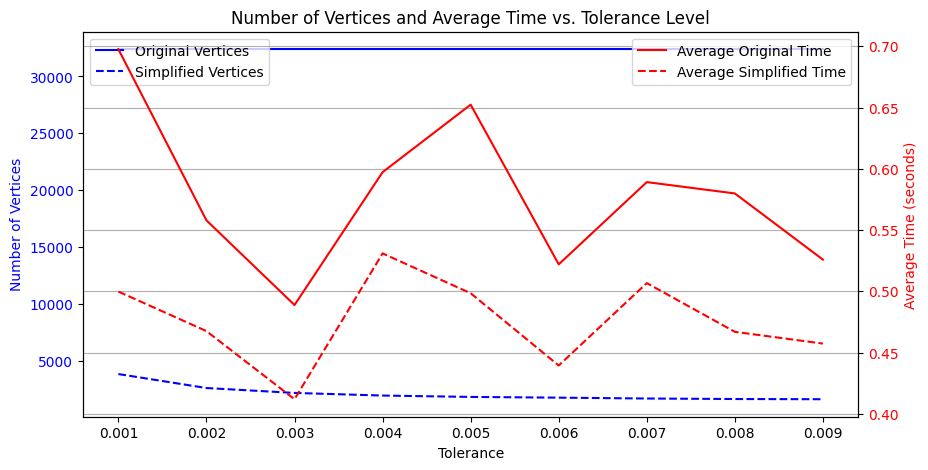

In [47]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Assuming 'original_vertices' and 'simplified_vertices' lists are already populated with the correct data
# Plot number of vertices on the first y-axis (left)
ax1.plot(tolerances, original_vertices, 'b-', label='Original Vertices')
ax1.plot(tolerances, simplified_vertices, 'b--', label='Simplified Vertices')
ax1.set_xlabel('Tolerance')
ax1.set_ylabel('Number of Vertices', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Create a second y-axis for the average times
ax2 = ax1.twinx()
ax2.plot(tolerances, average_times_original, 'r-', label='Average Original Time')
ax2.plot(tolerances, average_times_simplified, 'r--', label='Average Simplified Time')
ax2.set_ylabel('Average Time (seconds)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Number of Vertices and Average Time vs. Tolerance Level')
plt.grid(True)
plt.show()

In [48]:
tolerances = np.arange(0.001, 0.011, 0.001)  # Adjust this range as needed
accuracy_rates = []

for tol in tolerances:
    # Simplify
    neighborhoods_original_simplified['geometry'] = neighborhoods_original['geometry'].apply(
        lambda geom: geom.simplify(tol, preserve_topology=True))

    #spatial joins
    sjoined_neighborhoods_original = gpd.sjoin(gdf_trips, neighborhoods_original, predicate="within")
    sjoined_neighborhoods_simplified = gpd.sjoin(gdf_trips, neighborhoods_original_simplified, predicate="within")

    #merge dataframes to compare neighborhoods
    comparison_df = sjoined_neighborhoods_original.merge(
        sjoined_neighborhoods_simplified[['neighborhood']],
        left_index=True, right_index=True,
        suffixes=('_original', '_simplified')
    )

    # Calculate accuracy
    comparison_df['is_accurate'] = comparison_df['neighborhood_original'] == comparison_df['neighborhood_simplified']
    accuracy_rate = comparison_df['is_accurate'].mean() * 100
    accuracy_rates.append(accuracy_rate)
    print(f"Tolerance: {tol:.3f}, Accuracy Rate: {accuracy_rate:.2f}%")


Tolerance: 0.001, Accuracy Rate: 83.66%
Tolerance: 0.002, Accuracy Rate: 74.88%
Tolerance: 0.003, Accuracy Rate: 72.28%
Tolerance: 0.004, Accuracy Rate: 71.20%
Tolerance: 0.005, Accuracy Rate: 70.48%
Tolerance: 0.006, Accuracy Rate: 70.22%
Tolerance: 0.007, Accuracy Rate: 70.22%
Tolerance: 0.008, Accuracy Rate: 66.45%
Tolerance: 0.009, Accuracy Rate: 56.58%
Tolerance: 0.010, Accuracy Rate: 56.53%


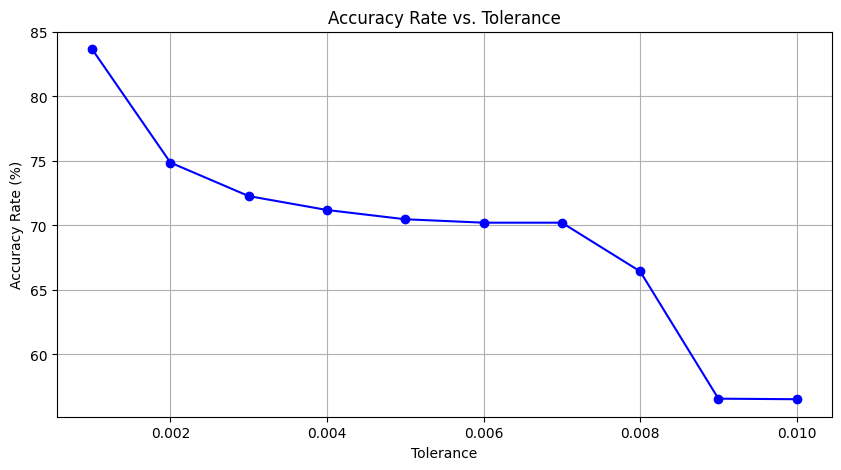

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(tolerances, accuracy_rates, marker='o', linestyle='-', color='b')
plt.title('Accuracy Rate vs. Tolerance')
plt.xlabel('Tolerance')
plt.ylabel('Accuracy Rate (%)')
plt.grid(True)
plt.show()


##C: Simplify using Mapshaper

In [50]:
!curl -sL https://deb.nodesource.com/setup_14.x | sudo -E bash -
!sudo apt-get install -y nodejs
!npm install -g mapshaper




                              DEPRECATION WARNING                            

  Node.js 14.x is no longer actively supported!

  You will not receive security or critical stability updates for this version.

  You should migrate to a supported version of Node.js as soon as possible.
  Use the installation script that corresponds to the version of Node.js you
  wish to install. e.g.

   * https://deb.nodesource.com/setup_16.x — Node.js 16 "Gallium"
   * https://deb.nodesource.com/setup_18.x — Node.js 18 LTS "Hydrogen" (recommended)
   * https://deb.nodesource.com/setup_19.x — Node.js 19 "Nineteen"
   * https://deb.nodesource.com/setup_20.x — Node.js 20 "Iron" (current)

  Please see https://github.com/nodejs/Release for details about which
  version may be appropriate for you.

  The NodeSource Node.js distributions repository contains
  information both about supported versions of Node.js and supported Linux
  distributions. To learn more about usage, see the repository:
    https:/

In [ ]:
!mapshaper '/content/drive/MyDrive/foundation project/nyc_polygon.geojson' -simplify dp 1% -o '/content/drive/MyDrive/foundation project/mapshaper_nyc_polygon_simplified.geojson'

[simplify] Repaired 49 intersections; 12 intersections could not be repaired
[o] Wrote /content/drive/MyDrive/foundation project/mapshaper_nyc_polygon_simplified.geojson


In [ ]:
mapshaper_simplified=gpd.read_file('/content/drive/MyDrive/foundation project/mapshaper_nyc_polygon_simplified.geojson')

In [ ]:
sjoin_mapshaper=gpd.sjoin(gdf_trips, mapshaper_simplified, predicate="within") #preform special join for the mapshaper simplified

In [ ]:
import folium

# Create a base map (adjust the location and zoom to fit your data)
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add the GeoJSON overlay to the folium map
folium.GeoJson(mapshaper_simplified, name="simplified_geometry").add_to(m)

# Display the map
m

##D: Comparison analysis between the mapshpaer and the Shapley

All the comparison will be build on based of tolerance 0.01(Shapley), or 1%(Mapshaper)

In [ ]:
def count_vertices(geom):
    if geom is None:
        return 0  # Return 0 if the geometry is None
    elif geom.geom_type == 'Polygon':
        return len(geom.exterior.coords)
    elif geom.geom_type == 'MultiPolygon':
        return sum(len(p.exterior.coords) for p in geom)
    return 0

In [ ]:
neighborhoods_original['vertex_count']=neighborhoods_original['geometry'].apply(count_vertices)
neighborhoods_original_simplified['vertex_count']=neighborhoods_original_simplified['geometry'].apply(count_vertices)
mapshaper_simplified['vertex_count']=mapshaper_simplified['geometry'].apply(count_vertices)

total_vertices_original = neighborhoods_original['vertex_count'].sum()
total_vertices_shapely = neighborhoods_original_simplified['vertex_count'].sum()
total_vertices_mapshaper = mapshaper_simplified['vertex_count'].sum()


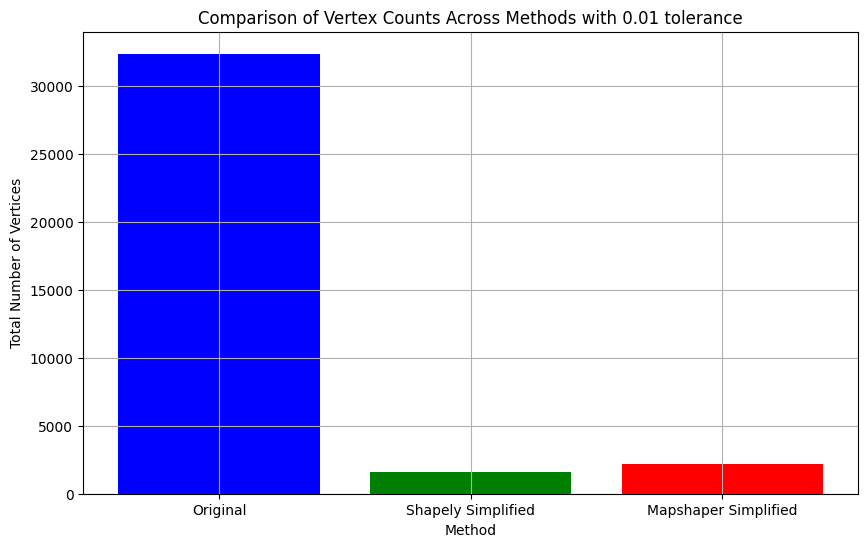

In [ ]:
categories = ['Original', 'Shapely Simplified', 'Mapshaper Simplified']
vertex_counts = [total_vertices_original, total_vertices_shapely, total_vertices_mapshaper]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(categories, vertex_counts, color=['blue', 'green', 'red'])
plt.title('Comparison of Vertex Counts Across Methods with 0.01 tolerance')
plt.xlabel('Method')
plt.ylabel('Total Number of Vertices')
plt.grid(True)
plt.show()


#Part 3: RMSE, RMSD, MAE, MAPE, R-Square

##A: Aggrigation

In [ ]:
#data aggrigation by neighborhood for original datasets

sjoined_neighborhoods_original['otherNAME'] = sjoined_neighborhoods_original['neighborhood']
sampled_data_original_grouped = sjoined_neighborhoods_original[['otherNAME','geometry','neighborhood']].groupby(['neighborhood'], as_index=False).agg({'otherNAME':'first','neighborhood': 'count', 'geometry': 'first'})
sampled_data_original_grouped.head(1)

#group the data based on the neighbourhood
#select the first occurance of the neighbourhood
#retrive the first geometry of each neighbourhood
#count the number of occurances of each neighbourhood

,otherNAME,neighborhood,geometry
0,Allerton,115,POINT (-73.86880 40.85723)


In [ ]:
#data aggrigation by neighborhood for simplified dataset

sjoined_neighborhoods_original_simplified['otherNAME'] = sjoined_neighborhoods_original_simplified['neighborhood']
sampled_data_simplified_grouped = sjoined_neighborhoods_original_simplified[['otherNAME','geometry','neighborhood']].groupby(['neighborhood'], as_index=False).agg({'otherNAME':'first','neighborhood': 'count', 'geometry': 'first'})
sampled_data_simplified_grouped.head(1)


,otherNAME,neighborhood,geometry
0,Allerton,114,POINT (-73.86848 40.85764)


In [ ]:
sjoin_mapshaper['otherNAME'] = sjoin_mapshaper['neighborhood']
sampled_data_simplified_mapshaper_grouped = sjoin_mapshaper[['otherNAME','geometry','neighborhood']].groupby(['neighborhood'], as_index=False).agg({'otherNAME':'first','neighborhood': 'count', 'geometry': 'first'})
sampled_data_simplified_mapshaper_grouped.head(1)

,otherNAME,neighborhood,geometry
0,Allerton,115,POINT (-73.86880 40.85723)


In [ ]:
np.sum(sampled_data_original_grouped.neighborhood)

169995

In [ ]:
np.sum(sampled_data_simplified_grouped.neighborhood)

136489

In [ ]:
np.sum(sampled_data_simplified_mapshaper_grouped.neighborhood)

168170

In [ ]:
sampled_data_original_grouped.shape

(48, 3)

In [ ]:
sampled_data_simplified_grouped.shape

(47, 3)

In [ ]:
sampled_data_simplified_mapshaper_grouped.shape

(47, 3)

The results of the aggregation shows the following:


*   counts: The count indicates that the Mapshper simplifer is better than the standard simplifier in preserving total counts
*   Merged boundaries: : The reduction in the number of neighborhoods in both simplified datasets suggests that simplification may lead to neighborhood boundaries being merged or certain neighborhoods being entirely subsumed into adjacent ones.
We can conclude the the Mapshper version of the DP simplified is more suitable and better for analyses where the geographic distribution and neighborhood integrity are crucial.


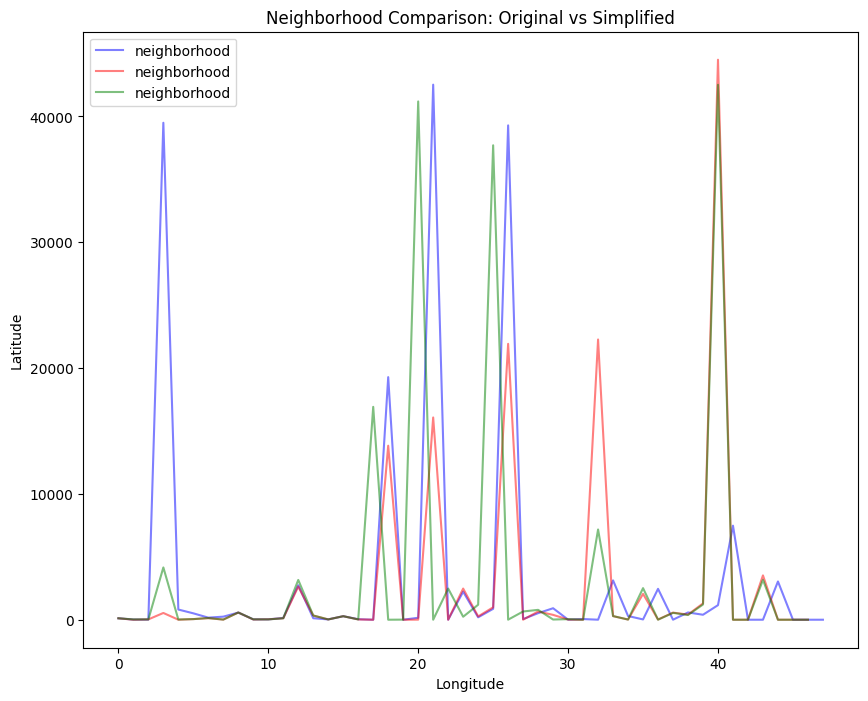

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
sampled_data_original_grouped.plot(ax=ax, color='blue', alpha=0.5, label='Original ')
sampled_data_simplified_grouped.plot(ax=ax, color='red', alpha=0.5, label='Simplified Standard')
sampled_data_simplified_mapshaper_grouped.plot(ax=ax, color='green', alpha=0.5, label='Simplified MapShaper')
plt.legend()
plt.title('Neighborhood Comparison: Original vs Simplified')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


##B: Normalizing

In [ ]:
#extract column count neighborhood to numpy array (original)
count_original = sampled_data_original_grouped['neighborhood'].to_numpy()
count_original

array([  115,    14,    11, 39495,   810,   509,   166,   245,   569,
          29,    29,   138,  2741,   120,    27,   281,    41,     2,
       19280,     1,   156, 42523,     1,  2229,   193,   867, 39287,
          53,   522,   914,     7,    54,     3,  3127,   296,    24,
        2456,     3,   579,   396,  1160,  7477,     1,     1,  3040,
           1,     1,     1])

In [ ]:
#extract column count neighborhood to numpy array (simplified)
count_simplifed = sampled_data_simplified_grouped['neighborhood'].to_numpy()
count_simplifed

array([  114,     4,    27,   538,     2,    50,   124,    10,   574,
          20,    34,   117,  2632,   334,    24,   281,    24,     1,
       13831,     1,     7, 16075,     1,  2477,   263,   987, 21926,
           5,   652,   387,    14,     1, 22272,   287,    16,  2055,
          16,   566,   407,  1299, 44505,     1,     1,  3524,     1,
           1,     1])

In [ ]:
#extract column count neighborhood to numpy array (mapshaper simplified)
count_mapshaper = sampled_data_simplified_mapshaper_grouped['neighborhood'].to_numpy()
count_mapshaper

array([  115,    26,    27,  4155,    19,    50,   135,    13,   575,
          31,    26,   117,  3162,   338,    24,   281,    24, 16919,
           1,     9, 41190,     1,  2477,   238,  1192, 37705,     5,
         655,   785,    16,    46,     2,  7171,   292,    14,  2511,
           4,   546,   376,  1209, 42515,     1,     1,  3168,     1,
           1,     1])

In [ ]:
# you need to normalize so that all add up to one
count_original_normalized = count_original/count_original.sum()
count_original_normalized

array([6.76490485e-04, 8.23553634e-05, 6.47077855e-05, 2.32330363e-01,
       4.76484602e-03, 2.99420571e-03, 9.76499309e-04, 1.44121886e-03,
       3.34715727e-03, 1.70593253e-04, 1.70593253e-04, 8.11788582e-04,
       1.61240036e-02, 7.05903115e-04, 1.58828201e-04, 1.65298979e-03,
       2.41183564e-04, 1.17650519e-05, 1.13415100e-01, 5.88252596e-06,
       9.17674049e-04, 2.50142651e-01, 5.88252596e-06, 1.31121504e-02,
       1.13532751e-03, 5.10015000e-03, 2.31106797e-01, 3.11773876e-04,
       3.07067855e-03, 5.37662872e-03, 4.11776817e-05, 3.17656402e-04,
       1.76475779e-05, 1.83946587e-02, 1.74122768e-03, 1.41180623e-04,
       1.44474837e-02, 1.76475779e-05, 3.40598253e-03, 2.32948028e-03,
       6.82373011e-03, 4.39836466e-02, 5.88252596e-06, 5.88252596e-06,
       1.78828789e-02, 5.88252596e-06, 5.88252596e-06, 5.88252596e-06])

In [ ]:
# you need to normalize so that all add up to one
count_simplifed_normalized = count_simplifed/count_simplifed.sum()
count_simplifed_normalized

array([8.35232143e-04, 2.93063910e-05, 1.97818139e-04, 3.94170959e-03,
       1.46531955e-05, 3.66329887e-04, 9.08498121e-04, 7.32659775e-05,
       4.20546711e-03, 1.46531955e-04, 2.49104323e-04, 8.57211936e-04,
       1.92836053e-02, 2.44708365e-03, 1.75838346e-04, 2.05877397e-03,
       1.75838346e-04, 7.32659775e-06, 1.01334173e-01, 7.32659775e-06,
       5.12861842e-05, 1.17775059e-01, 7.32659775e-06, 1.81479826e-02,
       1.92689521e-03, 7.23135198e-03, 1.60642982e-01, 3.66329887e-05,
       4.77694173e-03, 2.83539333e-03, 1.02572368e-04, 7.32659775e-06,
       1.63177985e-01, 2.10273355e-03, 1.17225564e-04, 1.50561584e-02,
       1.17225564e-04, 4.14685433e-03, 2.98192528e-03, 9.51725047e-03,
       3.26070233e-01, 7.32659775e-06, 7.32659775e-06, 2.58189305e-02,
       7.32659775e-06, 7.32659775e-06, 7.32659775e-06])

In [ ]:
# you need to normalize so that all add up to one
count_mapshaper_normalized = count_mapshaper/count_mapshaper.sum()
count_mapshaper_normalized

array([6.83831837e-04, 1.54605459e-04, 1.60551823e-04, 2.47071416e-02,
       1.12980912e-04, 2.97318190e-04, 8.02759113e-04, 7.73027294e-05,
       3.41915918e-03, 1.84337278e-04, 1.54605459e-04, 6.95724564e-04,
       1.88024023e-02, 2.00987096e-03, 1.42712731e-04, 1.67092823e-03,
       1.42712731e-04, 1.00606529e-01, 5.94636380e-06, 5.35172742e-05,
       2.44930725e-01, 5.94636380e-06, 1.47291431e-02, 1.41523458e-03,
       7.08806565e-03, 2.24207647e-01, 2.97318190e-05, 3.89486829e-03,
       4.66789558e-03, 9.51418208e-05, 2.73532735e-04, 1.18927276e-05,
       4.26413748e-02, 1.73633823e-03, 8.32490932e-05, 1.49313195e-02,
       2.37854552e-05, 3.24671463e-03, 2.23583279e-03, 7.18915383e-03,
       2.52809657e-01, 5.94636380e-06, 5.94636380e-06, 1.88380805e-02,
       5.94636380e-06, 5.94636380e-06, 5.94636380e-06])

The results showed after normalization indicates that the mapshaper preserves integrety better than the simplifier  

<font color='red' size=4> In conclusion, I will be using the original spatial join and comapre it with the mapshaper DP simplified spatial join

##C: Matrices

In [ ]:
from scipy.stats import spearmanr
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon

In [ ]:
#function to aggregate data and normalize counts (I took the dr code and created a function instead of repeating the operation)
def prepare_data(df):
    aggregated = df.groupby('neighborhood').size().reset_index(name='count')
    total = aggregated['count'].sum()
    aggregated['normalized_count'] = aggregated['count'] / total
    return aggregated

In [ ]:
original_counts = prepare_data(sjoined_neighborhoods_original)
simplified_counts = prepare_data(sjoin_mapshaper)

In [ ]:
# Merge to ensure both datasets have the same neighborhoods
comparison_df = pd.merge(original_counts, simplified_counts, on='neighborhood', suffixes=('_original', '_simplified'), how='outer').fillna(0)

In [ ]:
def MAPE(Y_actual, Y_predicted):
    y_actual, y_pred = np.array(Y_actual), np.array(Y_predicted)
    non_zero = y_actual != 0
    return np.mean(np.abs((y_actual[non_zero] - y_pred[non_zero]) / y_actual[non_zero])) * 100
#Measures the average deviation between the proportions of each neighborhood in the original and simplified data as a percentage.

In [ ]:
def RMSE(Y_actual, Y_predicted):
    return np.sqrt(np.mean(np.square(Y_predicted - Y_actual)))
#Provides a measure of the average magnitude of the error. The square root of the average of squared differences between actual and predicted values.

In [ ]:
mape_score = MAPE(comparison_df['normalized_count_original'], comparison_df['normalized_count_simplified'])
rmse_score = RMSE(comparison_df['normalized_count_original'], comparison_df['normalized_count_simplified'])
spearman_score = spearmanr(comparison_df['normalized_count_original'], comparison_df['normalized_count_simplified']).correlation
js_divergence = jensenshannon(comparison_df['normalized_count_original'], comparison_df['normalized_count_simplified'])
#Assesses how well the relationship between the original and simplified datasets can be described using a monotonic function,
#indicating if higher counts in the original tend to be higher in the simplified.

In [ ]:
# Output the results
print(f"MAPE: {mape_score:.2f}%")
print(f"RMSE: {rmse_score:.5f}")
print(f"Spearman Correlation: {spearman_score:.5f}")
print(f"Jensen-Shannon Divergence: {js_divergence:.5f}")

MAPE: 46.28%
RMSE: 0.04272
Spearman Correlation: 0.93295
Jensen-Shannon Divergence: 0.30801


So the matrices here calculate how much each neighbourhood divergece after simplification.
This method is essentially a way of analyzing how well the distribution of the original data is preserved in the simplified data, by looking at the normalized frequency (proportion) of occurrences in each neighborhood.

Now I will compute how the averages over pm 10 changes from the original to the simplified

In [ ]:
sjoined_neighborhoods_original.head(1)

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,temperature,humidity,pm25,geometry,index_right,neighborhood,boroughCode,borough,@id,otherNAME
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,23.7,57.3,4.508813,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...,Bronx Park


In [ ]:
#find average of PM10 of the original dataset
avg_original = sjoined_neighborhoods_original.groupby('neighborhood')['pm25'].mean().reset_index()
avg_original.rename(columns={'pm25': 'avg_pm_original'}, inplace=True)

#find average of PM10 of the simplified dataset
avg_simplified = sjoined_neighborhoods_simplified.groupby('neighborhood')['pm25'].mean().reset_index()
avg_simplified.rename(columns={'pm25': 'avg_pm_simplified'}, inplace=True)

In [ ]:
#merge the averages based on the neighbourhood
merged_averages = pd.merge(avg_original, avg_simplified, on='neighborhood', how='outer')

In [ ]:
def MAPE(Y_actual, Y_Predicted):
    return np.mean(np.abs((Y_actual - Y_Predicted) / Y_actual)) * 100

In [ ]:
def RMSE(Y_actual, Y_Predicted):
    return np.sqrt(np.mean((Y_actual - Y_Predicted)**2))


In [ ]:
#calculate the matrices
mape_score = MAPE(merged_averages['avg_pm_original'], merged_averages['avg_pm_simplified'])
rmse_score = RMSE(merged_averages['avg_pm_original'], merged_averages['avg_pm_simplified'])

In [ ]:
# Display the results
print(f"MAPE: {mape_score}")
print(f"RMSE: {rmse_score}")

MAPE: 5.687102974390701
RMSE: 0.4571363511600887


To conclude from the results above:


*   MAPE:  low average percentage error between the original and simplified data sets. This is considered good result in many contexts, suggesting that the simplification retains a fair amount of accuracy in terms of count.
*   RMSE: This result is high. This suggests that while some neighborhoods may align closely between the datasets, others differ significantly, possibly due to the simplification process affecting some areas more than others.



#Part 4: Visvalingam-Wyatt Simplifier

##A: Visvalingam-Wyatt with mapshaper

In [ ]:
!mapshaper '/content/drive/MyDrive/foundation project/nyc_polygon.geojson' -simplify visvalingam keep-shapes percentage=1% -o '/content/drive/MyDrive/foundation project/mapshaper_nyc_polygon_Visvalingam-Wyatt.geojson'

[simplify] Repaired 47 intersections; 8 intersections could not be repaired
[o] Wrote /content/drive/MyDrive/foundation project/mapshaper_nyc_polygon_Visvalingam-Wyatt.geojson


In [ ]:
mapshaper_Visvalingam_Wyatt=gpd.read_file('/content/drive/MyDrive/foundation project/mapshaper_nyc_polygon_Visvalingam-Wyatt.geojson')

In [ ]:
sjoin_mapshaper_Visvalingam_Wyatt=gpd.sjoin(gdf_trips, mapshaper_Visvalingam_Wyatt, predicate="within") #preform special join for the mapshaper Visvalingam_Wyatt

In [ ]:
import folium

# Create a base map (adjust the location and zoom to fit your data)
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add the GeoJSON overlay to the folium map
folium.GeoJson(mapshaper_simplified, name="simplified_geometry").add_to(m)

# Display the map
m

##B: Comparison analysis between original, DP, DP mapshaper, and Visvalingam Wyatt mapshaper

In [ ]:
mapshaper_Visvalingam_Wyatt['vertex_count']=mapshaper_Visvalingam_Wyatt['geometry'].apply(count_vertices)

total_vertices_mapshaper_Visvalingam_Wyatt = mapshaper_Visvalingam_Wyatt['vertex_count'].sum()

In [ ]:
print("The total number of vertices in the original dataset: ",total_vertices_original)
print("The total number of vertices in the DP simplified: ",total_vertices_shapely)
print("The total number of vertices in the DP simplified using mapshaper: ",total_vertices_mapshaper)
print("The total number of vertices in the simplified Visvalingam Wyatt using mapshaper: ",total_vertices_mapshaper_Visvalingam_Wyatt)

The total number of vertices in the original dataset:  32388
The total number of vertices in the DP simplified:  1632
The total number of vertices in the DP simplified using mapshaper:  2189
The total number of vertices in the simplified Visvalingam Wyatt using mapshaper:  2363


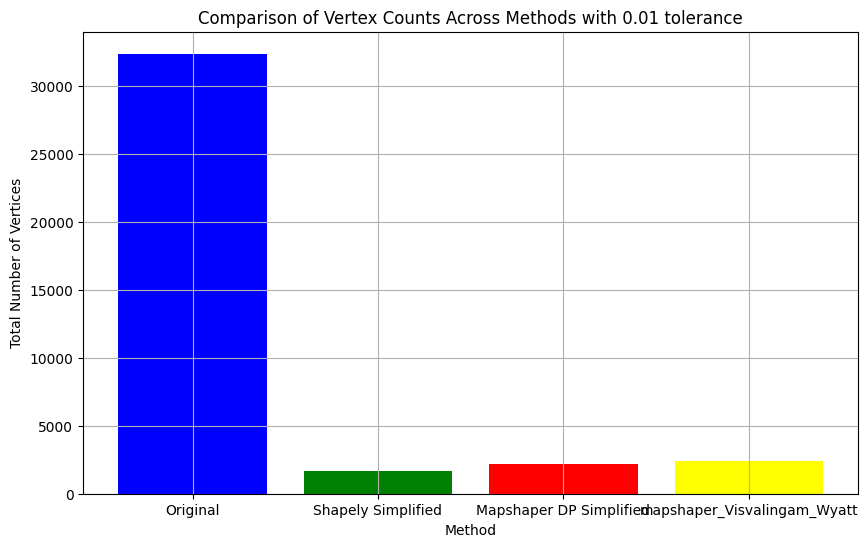

In [ ]:
categories = ['Original', 'Shapely Simplified', 'Mapshaper DP Simplified', 'mapshaper_Visvalingam_Wyatt']
vertex_counts = [total_vertices_original, total_vertices_shapely, total_vertices_mapshaper,total_vertices_mapshaper_Visvalingam_Wyatt]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(categories, vertex_counts, color=['blue', 'green', 'red','yellow'])
plt.title('Comparison of Vertex Counts Across Methods with 0.01 tolerance')
plt.xlabel('Method')
plt.ylabel('Total Number of Vertices')
plt.grid(True)
plt.show()

In [ ]:
#data aggrigation by neighborhood for mapshaper VW dataset
sjoin_mapshaper_Visvalingam_Wyatt['otherNAME'] = sjoin_mapshaper_Visvalingam_Wyatt['neighborhood']
sampled_data_simplified_mapshaper_Visvalingam_Wyatt_grouped = sjoin_mapshaper_Visvalingam_Wyatt[['otherNAME','geometry','neighborhood']].groupby(['neighborhood'], as_index=False).agg({'otherNAME':'first','neighborhood': 'count', 'geometry': 'first'})
sampled_data_simplified_mapshaper_Visvalingam_Wyatt_grouped.head(1)

,otherNAME,neighborhood,geometry
0,Allerton,115,POINT (-73.86880 40.85723)


In [ ]:
np.sum(sampled_data_simplified_mapshaper_Visvalingam_Wyatt_grouped.neighborhood)

168603

In [ ]:
sampled_data_simplified_mapshaper_Visvalingam_Wyatt_grouped.shape

(47, 3)

In [ ]:
#extract column count neighborhood to numpy array (mapshaper VW simplified)
count_mapshaper_Visvalingam_Wyatt = sampled_data_simplified_mapshaper_Visvalingam_Wyatt_grouped['neighborhood'].to_numpy()
count_mapshaper_Visvalingam_Wyatt

array([  115,    26,    27,  4155,    19,   544,   184,    13,   575,
          31,    34,   117,  3162,   338,    24,   281,    24, 16812,
           1,     9, 41190,     1,  2477,   238,  1192, 37705,     5,
         655,   785,    16,    46,     2,  7173,   295,    18,  2511,
           4,   546,   376,  1209, 42495,     1,     1,  3168,     1,
           1,     1])

In [ ]:
# you need to normalize so that all add up to one
count_mapshaper_Visvalingam_Wyatt_normalized = count_mapshaper_Visvalingam_Wyatt/count_mapshaper_Visvalingam_Wyatt.sum()
count_mapshaper_Visvalingam_Wyatt_normalized

array([6.82075645e-04, 1.54208407e-04, 1.60139499e-04, 2.46436896e-02,
       1.12690759e-04, 3.22651436e-03, 1.09132103e-03, 7.71042034e-05,
       3.41037823e-03, 1.83863870e-04, 2.01657147e-04, 6.93937830e-04,
       1.87541147e-02, 2.00470929e-03, 1.42346222e-04, 1.66663701e-03,
       1.42346222e-04, 9.97135282e-02, 5.93109257e-06, 5.33798331e-05,
       2.44301703e-01, 5.93109257e-06, 1.46913163e-02, 1.41160003e-03,
       7.06986234e-03, 2.23631845e-01, 2.96554628e-05, 3.88486563e-03,
       4.65590766e-03, 9.48974811e-05, 2.72830258e-04, 1.18621851e-05,
       4.25437270e-02, 1.74967231e-03, 1.06759666e-04, 1.48929734e-02,
       2.37243703e-05, 3.23837654e-03, 2.23009081e-03, 7.17069091e-03,
       2.52041779e-01, 5.93109257e-06, 5.93109257e-06, 1.87897013e-02,
       5.93109257e-06, 5.93109257e-06, 5.93109257e-06])

In [ ]:
mapshape_Visvalingam_Wyatt_counts = prepare_data(sjoin_mapshaper_Visvalingam_Wyatt)

In [ ]:
comparison_df = pd.merge(original_counts, mapshape_Visvalingam_Wyatt_counts, on='neighborhood', suffixes=('_original', '_mapshape_Visvalingam_Wyatt'), how='outer').fillna(0)

In [ ]:
mape_score = MAPE(comparison_df['normalized_count_original'], comparison_df['normalized_count_mapshape_Visvalingam_Wyatt'])
rmse_score = RMSE(comparison_df['normalized_count_original'], comparison_df['normalized_count_mapshape_Visvalingam_Wyatt'])
spearman_score = spearmanr(comparison_df['normalized_count_original'], comparison_df['normalized_count_mapshape_Visvalingam_Wyatt']).correlation
js_divergence = jensenshannon(comparison_df['normalized_count_original'], comparison_df['normalized_count_mapshape_Visvalingam_Wyatt'])

In [ ]:
# Output the results
print(f"MAPE: {mape_score:.2f}%")
print(f"RMSE: {rmse_score:.5f}")
print(f"Spearman Correlation: {spearman_score:.5f}")
print(f"Jensen-Shannon Divergence: {js_divergence:.5f}")

MAPE: 44.13%
RMSE: 0.04265
Spearman Correlation: 0.93872
Jensen-Shannon Divergence: 0.30674


In [ ]:
#find average of PM10 of the Visvalingam_Wyatt
avg_Visvalingam_Wyatt = sjoin_mapshaper_Visvalingam_Wyatt.groupby('neighborhood')['pm25'].mean().reset_index()
avg_Visvalingam_Wyatt.rename(columns={'pm25': 'avg_pm_Visvalingam_Wyatt'}, inplace=True)

In [ ]:
#merge the averages based on the neighbourhood
merged_averages = pd.merge(avg_original, avg_Visvalingam_Wyatt, on='neighborhood', how='outer')

In [ ]:
def MAPE(Y_actual, Y_Predicted):
    return np.mean(np.abs((Y_actual - Y_Predicted) / Y_actual)) * 100

In [ ]:
def RMSE(Y_actual, Y_Predicted):
    return np.sqrt(np.mean((Y_actual - Y_Predicted)**2))


In [ ]:
#calculate the matrices
mape_score = MAPE(merged_averages['avg_pm_original'], merged_averages['avg_pm_Visvalingam_Wyatt'])
rmse_score = RMSE(merged_averages['avg_pm_original'], merged_averages['avg_pm_Visvalingam_Wyatt'])

In [ ]:
# Display the results
print(f"MAPE: {mape_score}")
print(f"RMSE: {rmse_score}")

MAPE: 4.615534936762865
RMSE: 0.3777170258192779
